In [10]:
import pandas as pd
import gensim
from gensim.models.coherencemodel import CoherenceModel

In [11]:
data = pd.read_csv('../../../letter_korean_corpus.csv')
letter = data

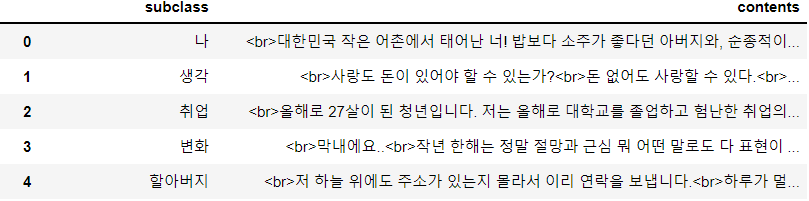

# 데이터 전처리

In [12]:
stopwords = [
    'stop', 'words'
]

In [13]:
from konlpy.tag import Okt
tagger = Okt()

# 편지 내용 가져오기
contents = letter['contents']

def preprocessing(text):
    # <br>제거
    text = text.replace("<br>", " ")
    
    # 형태소 분석
    okt_pos = tagger.pos(text, norm=True, stem=True)
    
    # 명사, 동사, 형용사 사용
    words = [word for word, hts in okt_pos if hts in ['Noun','Adjective', 'Verb']]
    
    # 스탑 워드 적용
    words = [word for word in words if word not in stopwords]
    
    return words

content = list(contents.apply(preprocessing))

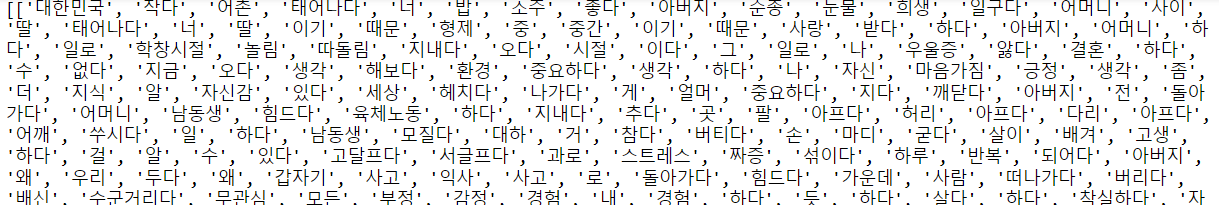

# 모델학습

In [14]:
from gensim import corpora

dictionary = corpora.Dictionary(content)
corpus = [dictionary.doc2bow(text) for text in content]

In [15]:
import gensim

NUM_TOPICS = 26  # 토픽 개수
ldamodel = gensim.models.ldamodel.LdaModel(
    corpus,
    num_topics=NUM_TOPICS,  #토픽 개수
    id2word=dictionary,
    passes=45,              # 전체 반복 횟수 == epoch
    iterations=500          # 한번 학습 반복 횟수 (iterations) * (passes)
)

## 검사

In [16]:
from gensim.models.coherencemodel import CoherenceModel

cm = CoherenceModel(model=ldamodel, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print("Cpherence",coherence)
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))

"""
    Cpherence 값 작을 수록 좋음
    Perplexity값 클수록 좋음
"""

Cpherence -1.2489006353258132

Perplexity:  -7.0671918585788465


'\n    Cpherence 값 작을 수록 좋음\n    Perplexity값 클수록 좋음\n'

In [17]:
topics = ldamodel.print_topics(num_words=4) #num_words == 하나의 토픽당 가장 가중치가 높은 단어 개수의 출력 개수

"""
    출력값 읽는 법
    (토픽의 번호, '가중치*단어' + '가중치*단어')
"""

"\n    출력값 읽는 법\n    (토픽의 번호, '가중치*단어' + '가중치*단어')\n"

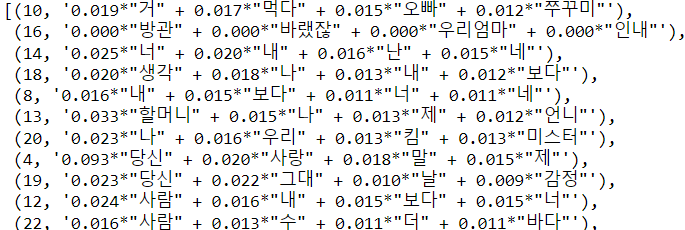

## epoch 계산

In [18]:
"""
    최적의 결과를 얻기 위해서 epoch수와 토픽의 개수를 계산하는게 좋다
"""

'\n    최적의 결과를 얻기 위해서 epoch수와 토픽의 개수를 계산하는게 좋다\n'

In [19]:
coherences=[]
perplexities=[]
passes=[]

#range(진행할 횟수)
for i in range(10):
    
    #epoch 계산을 위해서 토픽 개수 고정
    ntopics, nwords = 26, 100
    
    #처음에는 epoch한번
    if i==0:
        p=1
    #이후에 5개씩 추가해서 결과 확인
    else:
        p=i*5
        
    lda4 = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=ntopics, iterations=500, passes=p)
    print('epoch', p)

    cm = CoherenceModel(model=lda4, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence) #작을수록 좋음
    coherences.append(coherence) #클수록 좋음
    print('Perplexity: ', lda4.log_perplexity(corpus),'\n\n')
    perplexities.append(lda4.log_perplexity(corpus))

epoch 1
Cpherence -0.9056356593004609
Perplexity:  -7.3816948236595925 


epoch 5
Cpherence -0.9063080917739602
Perplexity:  -7.2216741793825765 


epoch 10
Cpherence -1.5392821155556387
Perplexity:  -7.095080602500916 


epoch 15
Cpherence -1.2475533583085072
Perplexity:  -7.0939293521248175 


epoch 20
Cpherence -1.2887812902868037
Perplexity:  -7.0862124008620935 


epoch 25
Cpherence -0.9204652335488971
Perplexity:  -7.122172407070972 


epoch 30
Cpherence -1.8000484038896944
Perplexity:  -7.092001158586736 




KeyboardInterrupt: 

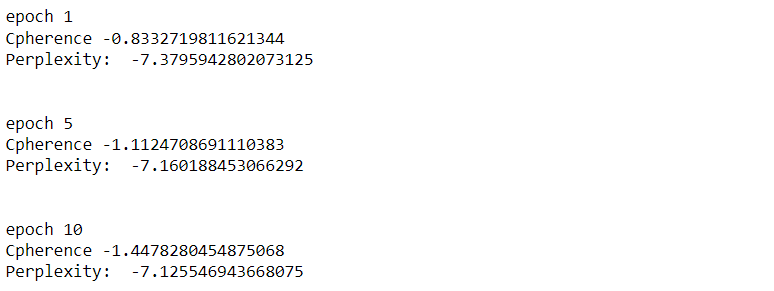

## 토픽 수 계산

In [ ]:
coherences=[]
perplexities=[]
passes=[]

#range(진행할 횟수)
for i in range(10):
    
    #처음에는 토픽수 2개
    if i==0:
        ntopics = 2
    #이후에 5개씩 추가해서 결과 확인
    else:
        ntopics = 5*i
        
    lda4 = gensim.models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=ntopics, iterations=400, passes=35)
    print('ntopics', ntopics)

    cm = CoherenceModel(model=lda4, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherences.append(coherence)
    print('Perplexity: ', lda4.log_perplexity(corpus),'\n\n')
    perplexities.append(lda4.log_perplexity(corpus))

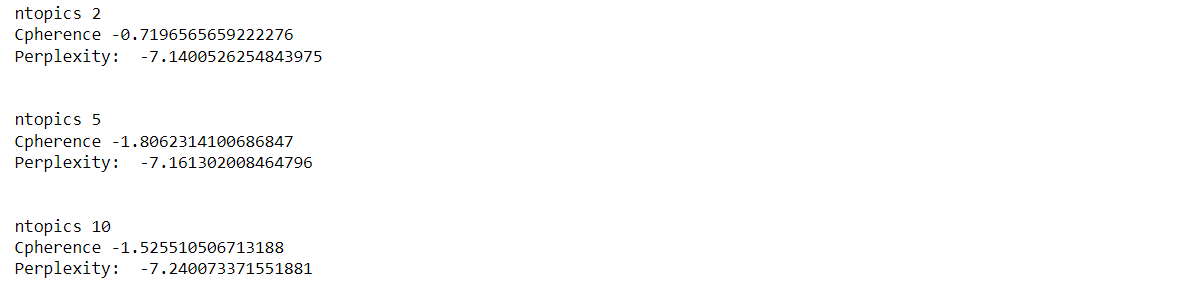

# 토픽 수기 작성용 파일 내보내기

In [ ]:
"""
    LDA모델은 전체 입력데이터로부터 빈도수를 기반으로 토픽을 추출해준다.
    EX) 사랑이라는 단어가 전체적으로 많이 나오면 사랑이라는 키워드와 함께 나온 단어들을 묶어서 하나의 토픽으로 구분
    이때 토픽의 개수는 사람이 입력해주어야 한다
    
    또한 결과로 나온 토픽 역시 추출한 단어들을 보고 사람이 어떤 토픽인지 판단하는 과정이 필요하다
    EX) (10, '0.68*'점심' + '0.35*'김치' + '0.30*'밥' + '0.20*'잡곡' + '0.7*'젓가락')
    -> 10번 토픽은 밥, 식사, 음식, 요리 등의 이름으로 토픽 지정할 수 있음
"""

In [ ]:
NUMWORDS = 20 # 토픽당 내보낼 문자 개수

LDA_analysis = pd.DataFrame()
word_list = []
for index, onetopic in enumerate(ldamodel.show_topics(formatted=False, num_topics=ldamodel.num_topics, num_words=NUMWORDS)):

    for i in range(NUMWORDS):
        wordstring = ""
        for words in onetopic[1]:
            wordstring += words[0] + ","
            
    word_list.append(wordstring)
    
LDA_analysis[index] = word_list

In [ ]:
LDA_analysis.to_csv('letter_lda_topics.csv', index=False)

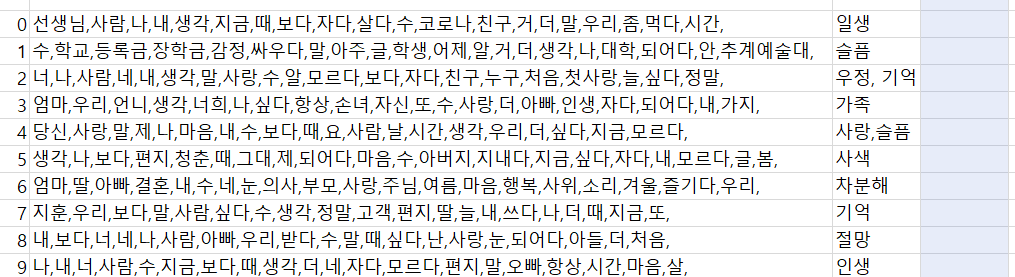  

이런 방식으로 수기로 토픽 작성함

# 토픽 검사
토픽을 수기로 검사할 때 편지가 정말 해당 토픽에 해당하는지,  
같은 토픽에 묶인 편지들은 어떤 내용인지 등등  
실제로 편지의 내용을 확인하기 위한 참고 코드

In [20]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        # 각 문서에 대해서 비중이 높은 토픽순으로 토픽을 정렬한다.
        # EX) 정렬 전 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (10번 토픽, 5%), (12번 토픽, 21.5%), 
        # Ex) 정렬 후 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (12번 토픽, 21.5%), (10번 토픽, 5%)
        # 48 > 25 > 21 > 5 순으로 정렬이 된 것.

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
            else:
                break
    return(topic_table)

In [21]:
topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']

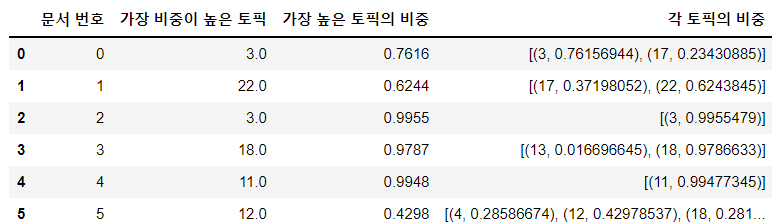

In [22]:
topic = 25.0 # 보고 싶은 토픽 넘버
topic_num = topictable[topictable['가장 비중이 높은 토픽'] == topic]['문서 번호']

In [23]:
a = [letter.iloc[rn].contents for rn in topic_num]
print(len(a)) # 해당 토픽에 걸리는 편지의 개수
a[:30] # 해당 토픽에 걸리는 편지 내용 출력

2


['<br>안녕하세요, 선생님. 저예요. 당신의 유일한 팬이에요.<br>저번 주에 열린 연주회는 정말 굉장했어요. 작곡가로서뿐만 아니라 피아니스트로서도 완벽한 공연이었습니다. 전 태어나서 그렇게 고요하고 아름다운 노래 연주는 처음 들어보았답니다. 눈을 감고 듣고 있으니, 마치 하늘에서 우릴 내려다보던 신이 내려와 피아노 건반을 두드리고 있는 것 같았어요. 아니, 어쩌면 신보다 더 초월하고 완벽한 존재였을지도 모르겠네요.<br>공연 관람을 끝내고 나왔을 때 제 손을 내려다보았어요. 하지만 선생님께 시기와 질투를 느끼지 않았답니다. 그저 나도 그 자리까지 오를 수 있을까 하는 생각밖에 들지 않았어요. 선생님과 어깨를 나란히 할 수 있다면 얼마나 좋을까. 선생님이 든 왕관의 절반을 내가 붙잡을 수만 있다면 뭐든 할 수 있을 텐데. 그런 생각이 들었답니다.<br>차가운 바닷바람이 부는 집으로 돌아왔을 땐 벌써 늦은 밤이었어요. 전 파도 소리를 들으며 제 검은 피아노 앞에 무심코 앉았습니다. 그리고 오른손으로 건반을 눌렀습니다. 댕, 하고 탁하고 더러운 소리가 방 안에 울리더군요. 조율도 완벽하고 어떤 것보다 값비싼 피아노일텐데 왜 이렇게 끔찍한 소리가 나는지 화가 났습니다. 피아노 의자를 박차고 일어나 주변을 둘러보았습니다. 진정할 필요가 있었어요.<br>전 부엌으로 가다 잠시 멈춰 섰습니다. 거실의 테이블 위에 처음 보는 편지 봉투가 놓여있었어요. 아주 고급스러운 종이 위에는 우아한 필기체로 제 이름이 적혀 있었어요. 오, 제가 어떻게 그 글씨를 알아보지 못할까요. 그 글씨체는 누가 봐도 선생님의 글씨체였습니다. 선생님께서 제게 손수 편지를 적어 보내신 것이었어요. 저는 그 사실을 알아차리는 순간 숨을 쉴 수 없었습니다. 두 손으로 가슴을 두드리며 소리 없이 비명을 질렀습니다.<br>편지를 펼쳐보았습니다. 그 안에는 제가 쓴 선생님의 일생과 작품에 관한 책에 대한 짧은 감상문과 함께 초대한다는 내용이 적혀있었습니다. 주소는 처음 보는 곳이었어요. 제가 사는 곳, 그

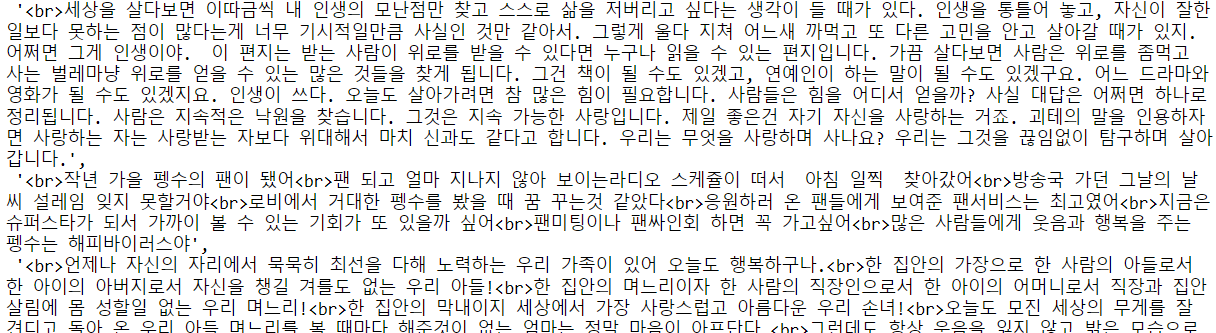

# 결과 CSV 파일 내보내기
각 편지에 해당하는 토픽을 레이블링한 CSV 결과 파일 내보내기

In [24]:
letter_dataframe = pd.DataFrame()

In [25]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame(columns = [0,1,2])

    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list    
        # 가장 높은 확률로 매칭되는 토픽을 확인하기 위해 토픽 가중치 내림차순으로 정렬
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        
        topic_list = []
        for j, (topic_num, prop_topic) in enumerate(doc):
            # 편지의 토픽 가중치, 즉 토픽에 해당하는 확률이 50%가 넘는 토픽만 레이블링함
            if prop_topic >= 0.50:
                # 분류된 단어들이 너무 공통점이 없어서 토픽 클래스를 분류하지 못한 토픽은 제외
                if topic_num not in (12, 13, 14, 16, 21, 22, 24, 25):
                    topic_list.append(topic_num)
            if j == 2:
                break
        
        
        # 편지를 데이터 형변환 후 단어가 2개 이하인 경우 남은 컬럼을 -1로 채워줌
        # 데이터 프레임을 만들때 컬럼수가 다르면 만들 수 없기 때문에 처리
        for index in range(3):
            if len(topic_list) < 3:
                topic_list.append(-1)

        topic_table.loc[i] = topic_list
    return(topic_table)

In [26]:
letter_topictable = make_topictable_per_doc(ldamodel, corpus)

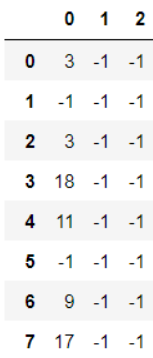

In [27]:
letter_topictable.to_csv('letter_LDA_ranking_more_50P.csv', index=False)